## Data exploration and cleaning

First part of the exercise:

> - Download and assess the data.
> - Identify and document any issues with the data.
> - Document how you resolved these issues.

### Download and asses the data

A basic inspection of the [website html](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml) reveals that all the CSV files I need contain the pattern *yellow_tripdata*. Given the size of the files I think the fastest and easier way to download the data is with a small _bash_ script.

The _bash_ script downloads the html source, takes the CSV sources and downloads them. Bellow is the code:

```bash
URL='http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml'
YELLOW_CSV=$(curl -s $URL | grep -E 'yellow_tripdata_2017-(03|06|11)' | sed 's/.*href="//' | sed 's/".*//')
for file in $YELLOW_CSV; do
  echo $file
  name=$(echo $file | cut -d'/' -f 6)
  curl $file -o $name
done
```

Whole code is in `download.sh`

Bellow is the code to clean the data. I chose R to explore the data given the stack of libraries dedicated to it. Summary and model notebooks are based on data exported from this notebook. 

In [1]:
library(dplyr)

files2017 <- list.files(path = paste0(getwd(), '/data/'), pattern = 'yellow_tripdata*', full.names = T)
df <- purrr::map_dfr(files2017, readr::read_csv)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Parsed with column specification:
cols(
  VendorID = col_integer(),
  tpep_pickup_datetime = col_datetime(format = ""),
  tpep_dropoff_datetime = col_datetime(format = ""),
  passenger_count = col_integer(),
  trip_distance = col_double(),
  RatecodeID = col_integer(),
  store_and_fwd_flag = col_character(),
  PULocationID = col_integer(),
  DOLocationID = col_integer(),
  payment_type = col_integer(),
  fare_amount = col_double(),
  extra = col_double(),
  mta_tax = col_double(),
  tip_amount = col_double(),
  tolls_amount = col_double(),
  improvement_surcharge = col_double(),
  total_amount = col_double()
)
Parsed with column specification:
cols(
  VendorID = col_integer(),
  tpep_pickup_datetime = col_datetime(format = ""),
  tpep_dropoff_datetime = col_datetime(format = ""),
  passenger

In [2]:
str(df)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	29236424 obs. of  17 variables:
 $ VendorID             : int  2 2 2 2 2 1 1 1 1 2 ...
 $ tpep_pickup_datetime : POSIXct, format: "2017-03-09 21:30:11" "2017-03-09 21:47:00" ...
 $ tpep_dropoff_datetime: POSIXct, format: "2017-03-09 21:44:20" "2017-03-09 21:58:01" ...
 $ passenger_count      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ trip_distance        : num  4.06 2.73 2.27 3.86 3.45 2.8 6 8.7 3.7 4.21 ...
 $ RatecodeID           : int  1 1 1 1 1 1 1 1 1 1 ...
 $ store_and_fwd_flag   : chr  "N" "N" "N" "N" ...
 $ PULocationID         : int  148 48 79 237 41 261 87 142 68 261 ...
 $ DOLocationID         : int  48 107 162 41 162 79 142 181 141 163 ...
 $ payment_type         : int  1 2 1 1 2 1 1 1 1 1 ...
 $ fare_amount          : num  14 11.5 10 12 12 12.5 19.5 30 16.5 20.5 ...
 $ extra                : num  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0 ...
 $ mta_tax              : num  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ...
 $ tip_amount           : num

In [3]:
# Explore missing variables
library(naniar)
miss_var_summary(df)

variable,n_miss,pct_miss
VendorID,0,0
tpep_pickup_datetime,0,0
tpep_dropoff_datetime,0,0
passenger_count,0,0
trip_distance,0,0
RatecodeID,0,0
store_and_fwd_flag,0,0
PULocationID,0,0
DOLocationID,0,0
payment_type,0,0


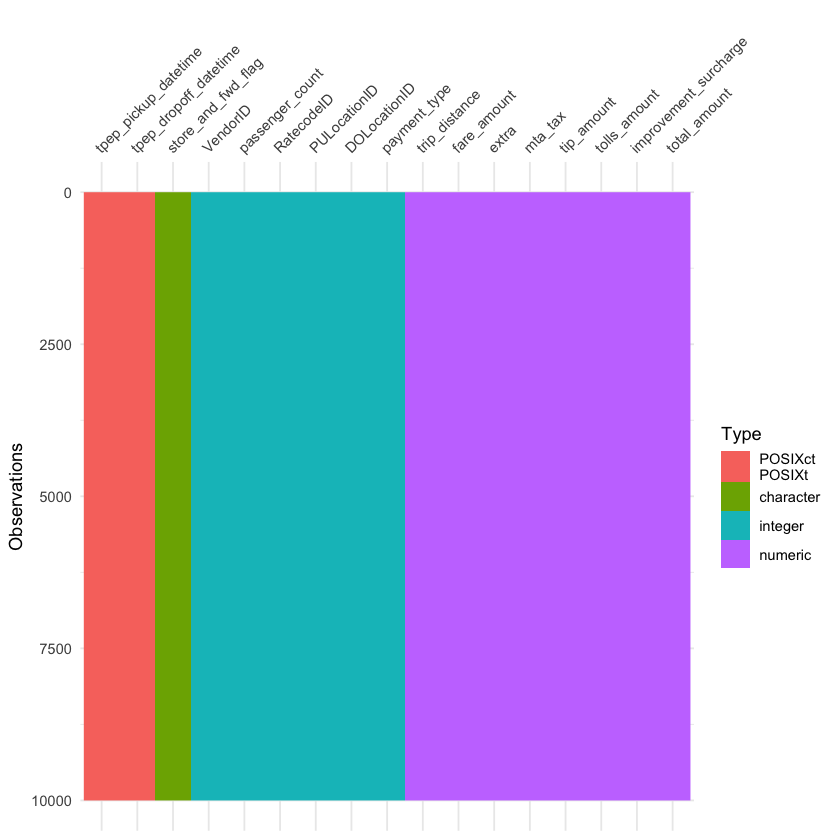

In [4]:
# Explore types of variables
library(visdat)
sample_df <- df %>%
    sample_n(10e3)
vis_dat(sample_df, warn_large_data=FALSE)

In [9]:
# Explore expectations of variables: eg VendorID should be 1 or 2
df %>% group_by(VendorID) %>%
    summarise(n = n())

VendorID,n
1,13276147
2,15960277


In [8]:
df %>% group_by(RatecodeID) %>%
    summarise(n = n())

RatecodeID,n
1,28407414
2,652907
3,61946
4,15533
5,97859
6,241
99,524


In [10]:
df %>% group_by(store_and_fwd_flag) %>%
    summarise(n = n())

store_and_fwd_flag,n
N,29111958
Y,124466


In [11]:
df %>% group_by(payment_type) %>%
    summarise(n = n())

payment_type,n
1,19844531
2,9194104
3,154080
4,43708
5,1


In [15]:
# I found an anomaly in the RateCodeID which should be between 1 and 6
df %>% 
    filter(RatecodeID == 99) %>%
    nrow()

[1] 524

In [4]:
df %>% group_by(lubridate::date(tpep_pickup_datetime), lubridate::date(tpep_dropoff_datetime)) %>%
    summarise(n = n())

lubridate::date(tpep_pickup_datetime),lubridate::date(tpep_dropoff_datetime),n
2001-01-01,2001-01-01,1
2008-12-31,2008-12-31,5
2008-12-31,2009-01-01,1
2009-01-01,2009-01-01,21
2017-03-01,2017-03-01,339219
2017-03-01,2017-03-02,2859
2017-03-02,2017-03-02,368831
2017-03-02,2017-03-03,4026
2017-03-03,2017-03-03,389630
2017-03-03,2017-03-04,5774


In [3]:
df %>% group_by(passenger_count, RatecodeID) %>%
    summarise(n = n())

passenger_count,RatecodeID,n
0,1,49154
0,2,1027
0,3,131
0,4,28
0,5,969
0,99,451
1,1,20396692
1,2,438207
1,3,42362
1,4,11009


In [4]:
readr::write_csv(df %>%
                 filter(lubridate::year(tpep_pickup_datetime) == 2017) %>%
                 filter(lubridate::month(tpep_pickup_datetime) %in% c(03, 06, 11)) %>%
                 filter(passenger_count < 10), 
                 'data/030611-2017_trips.csv')

### Identify and document any issues with the data and document the resolution

- _RateCodeID_ has a different range of values from the dictionary, I assume this means something and can affect on the total price.
- _Dates_ are different from the range we should be working with which is March, June, and November 2017. I chose delete those dates from the dataset assuming those are errors.
- The passenger count goes from 0 to 192. Fortunately, 192 is just one observation but 0 passengers appears in 51.760 observations. I compared with the RateCodeID and turns out to be a normal fare. So I treat it as a normal number of passengers, just to see how it plays in the model. There are some anomalies like 2 passengers with a group rate but since the number of passengers is a driver entered number I assume is a human error.